<a href="https://colab.research.google.com/github/oussezz/PFE_Results/blob/main/resnet152TrainingState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

In [ ]:
!pip install datasets[vision]
import os

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

# Définir les répertoires de données
data_dir = '../'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

# Définir la taille de batch
batch_size = 8

# Définir les transformations pour les données d'entraînement et de test
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Charger les ensembles d'entraînement et de test
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['Training', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
class_names = image_datasets['Training'].classes

# Définir le dispositif d'entraînement
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Définir le modèle pré-entraîné DenseNet-201
import torch
import torch.nn as nn
import torchvision

# Define the pre-trained ResNet-152 model
model_ft = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V1)

# Modify the last fully connected layer for binary classification
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the specified device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)


# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)

# Définir le planificateur de taux d'apprentissage
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [ ]:
# Définir la fonction pour entraîner le modèle
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['Training', 'Test']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to testing mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Training':
                scheduler.step()

            # Save epoch loss and accuracy
            if phase == 'Training':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model weights
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best Test Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return the trained model and the train and test losses and accuracies
    return model, train_losses, train_accs, test_losses, test_accs


               


In [ ]:
# Train the model
model_ft, train_losses, train_accs, test_losses, test_accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)


Epoch 0/49
----------
Training Loss: 0.2386 Acc: 0.9233
Test Loss: 0.7143 Acc: 0.6169

Epoch 1/49
----------
Training Loss: 0.1433 Acc: 0.9506
Test Loss: 0.5992 Acc: 0.6893

Epoch 2/49
----------
Training Loss: 0.1128 Acc: 0.9610
Test Loss: 0.6061 Acc: 0.6910

Epoch 3/49
----------
Training Loss: 0.0973 Acc: 0.9674
Test Loss: 0.6175 Acc: 0.6789

Epoch 4/49
----------
Training Loss: 0.0799 Acc: 0.9737
Test Loss: 0.6876 Acc: 0.6415

Epoch 5/49
----------
Training Loss: 0.0707 Acc: 0.9756
Test Loss: 0.6188 Acc: 0.6884

Epoch 6/49
----------
Training Loss: 0.0641 Acc: 0.9790
Test Loss: 0.6380 Acc: 0.6809

Epoch 7/49
----------
Training Loss: 0.0607 Acc: 0.9809
Test Loss: 0.6508 Acc: 0.6664

Epoch 8/49
----------
Training Loss: 0.0593 Acc: 0.9806
Test Loss: 0.6728 Acc: 0.6549

Epoch 9/49
----------
Training Loss: 0.0571 Acc: 0.9814
Test Loss: 0.6971 Acc: 0.6558

Epoch 10/49
----------
Training Loss: 0.0603 Acc: 0.9805
Test Loss: 0.7374 Acc: 0.6268

Epoch 11/49
----------
Training Loss: 0.05

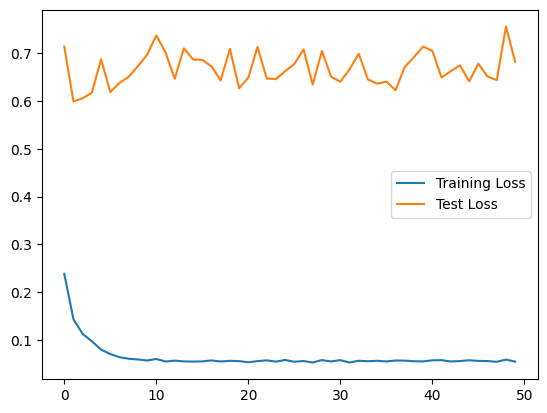

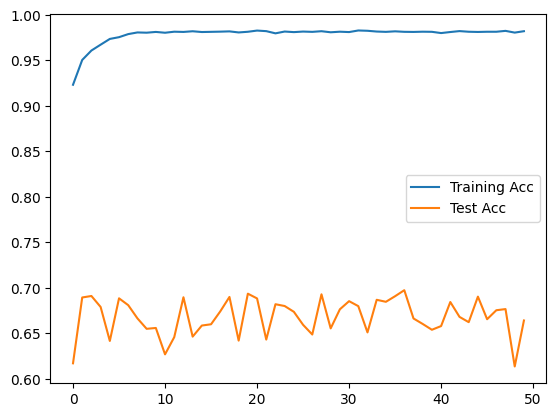

[[3899 1238]
 [1370 2110]]


In [ ]:
# Plot the train and test losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()
train_accs = [t.cpu() for t in train_accs]
test_accs = [t.cpu() for t in test_accs]
plt.plot(train_accs, label='Training Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend()
plt.show()

# Get the confusion matrix
y_test = []
y_pred = []
model_ft.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# Save the model
torch.save(model_ft.state_dict(), 'fire_classifier_resnet152.pth')

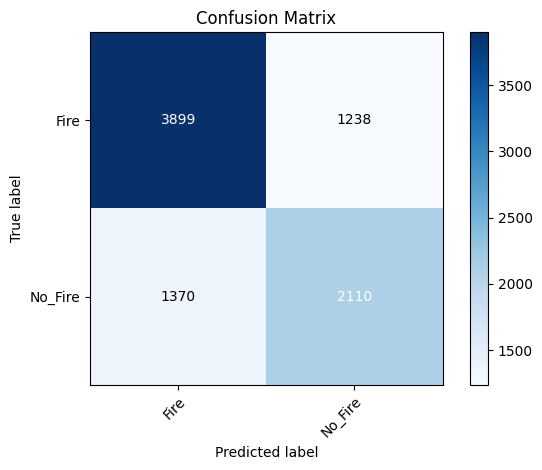

In [ ]:

# Plot the confusion matrix
classes = ['Fire', 'No_Fire']
fig, ax = plt.subplots()
im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(conf_mat.shape[1]),
       yticks=np.arange(conf_mat.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f' if conf_mat.max() < 1 else 'd'
thresh = conf_mat.max() / 2.
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, format(conf_mat[i, j], fmt),
                ha="center", va="center",
                color="white" if conf_mat[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
import sklearn.metrics as metrics

# assume y_test and y_pred are your true labels and predicted labels, respectively
conf_mat = metrics.confusion_matrix(y_test, y_pred)

# compute various classification metrics
accuracy = (conf_mat[0, 0] + conf_mat[1, 1]) / np.sum(conf_mat)
precision = conf_mat[0, 0] / np.sum(conf_mat[:, 0])
recall = conf_mat[0, 0] / np.sum(conf_mat[0, :])
f1_score = 2 * precision * recall / (precision + recall)

# print the results
print("Confusion Matrix:")
print(conf_mat)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1_score))

Confusion Matrix:
[[3899 1238]
 [1370 2110]]
Accuracy: 0.6973
Precision: 0.7400
Recall: 0.7590
F1 Score: 0.7494
